In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, make_scorer
from bayes_opt import BayesianOptimization
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score, LeaveOneOut, GridSearchCV, RandomizedSearchCV, StratifiedKFold

In [5]:
ftalany_class = pd.read_excel('ftalany_klasyfikacjaDT.xlsx', sheet_name=['X_train', 'y_train', 'X_test', 'y_test'])
Xt = ftalany_class['X_train']
Yt = ftalany_class['y_train']
Xv = ftalany_class['X_test']
Yv = ftalany_class['y_test']
Xt = Xt.rename(columns={"qc-": "qc"})
Xv = Xv.rename(columns={"qc-": "qc"})

In [6]:
correlation_matrix = Xt.cov().corr()

W zbiorze treningowym w Yt jest 13 obiektów zaklasyfikowanych do 2 kategorii (daje to 13/23) i 10 zaklasyfikowanych do 1 kategorii (co daje 10/23).

In [7]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(Xt, Yt)

[Text(0.4, 0.8333333333333334, 'x[3] <= -0.12\ngini = 0.491\nsamples = 23\nvalue = [10.0, 13.0]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 11\nvalue = [0, 11]'),
 Text(0.30000000000000004, 0.6666666666666667, 'True  '),
 Text(0.6, 0.5, 'x[2] <= 0.277\ngini = 0.278\nsamples = 12\nvalue = [10, 2]'),
 Text(0.5, 0.6666666666666667, '  False'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 10\nvalue = [10, 0]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]')]

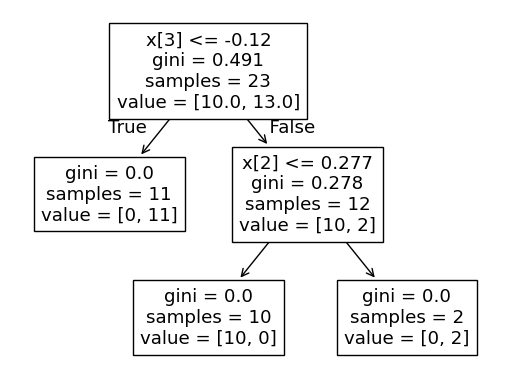

In [8]:
tree.plot_tree(clf)

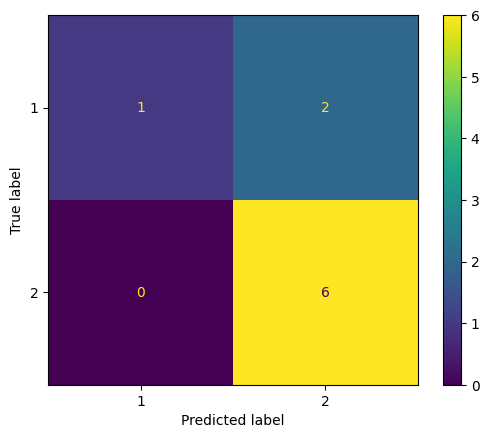

In [9]:
conmat = confusion_matrix(Yv, clf.predict(Xv))
conmandis = ConfusionMatrixDisplay(confusion_matrix=conmat, display_labels=clf.classes_)
conmandis.plot()
plt.show()

In [10]:
tn, fp, fn, tp = conmat.ravel()
print(f'Sensivity = {tp/(tp+fn)}\nSpecificity = {tn/(fp+tn)}\nPrecision = {tp/(tp+fp)}\nF1 = {(2*tp)/(2*tp+fp+fn)}\nBalanced accuracy = {((tp/(tp+fn))+(tn/(tp+tn))/2)}\nBalanced error = {1 - ((tp/(tp+fn))+(tn/(tp+tn))/2)}')

Sensivity = 1.0
Specificity = 0.3333333333333333
Precision = 0.75
F1 = 0.8571428571428571
Balanced accuracy = 1.0714285714285714
Balanced error = -0.0714285714285714


UZASADNIENIE WYBORU OPTYMALIZACJI BAYESOWSKIEJ:


Jest wskazana dla małych i niezbalansowanych zbiorów danych, pod warunkiem że dostosuje się odpowiednie parametry. Użycie: funkcji celu do specyfiki problemu (np. F1-Score lub AUC-ROC) oraz stratyfikowanej walidacji krzyżowej. Przy ekstremalnie małych zbiorach może nie poradzić sobie najlepiej, dlatego stosuję ją bardziej w formie kontry do innych metod.

|   iter    |  target   | criterion | max_depth | min_sa... | min_sa... |
-------------------------------------------------------------------------
| 1         | 0.7       | 0.3745    | 47.59     | 7.588     | 12.78     |
| 2         | 0.7       | 0.156     | 8.644     | 1.523     | 17.59     |
| 3         | 0.66      | 0.6011    | 35.7      | 1.185     | 19.46     |
| 4         | 0.74      | 0.8324    | 11.4      | 2.636     | 5.301     |
| 5         | 0.7       | 0.3042    | 26.71     | 4.888     | 7.242     |
| 6         | 0.7       | 0.6119    | 7.835     | 3.629     | 8.595     |
| 7         | 0.74      | 0.4561    | 39.47     | 2.797     | 11.26     |
| 8         | 0.65      | 0.5924    | 3.276     | 6.468     | 5.069     |
| 9         | 0.78      | 0.06505   | 47.5      | 9.691     | 16.55     |
| 10        | 0.65      | 0.3046    | 5.786     | 7.158     | 9.923     |
| 11        | 0.7       | 0.122     | 25.26     | 1.309     | 18.37     |
| 12        | 0.7       | 0.2588    | 

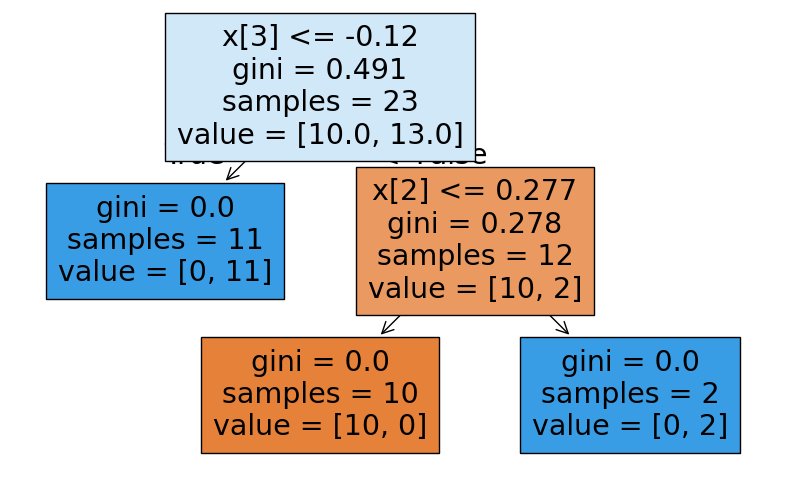

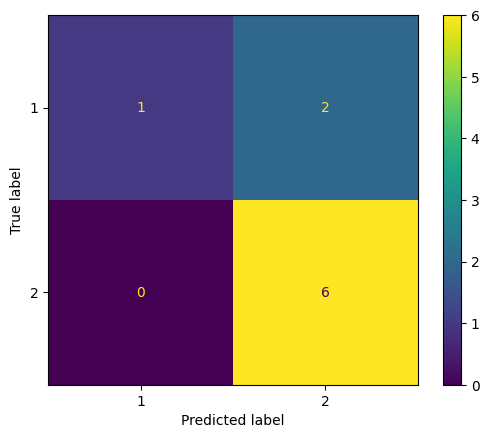

Precision: 0.8333333333333334
Recall: 0.7777777777777778
F1-Score: 0.738095238095238


In [61]:
def optimize_dt(criterion, max_depth, min_samples_split, min_samples_leaf):
    criterion = 'gini' if criterion < 0.5 else 'entropy'
    dt = tree.DecisionTreeClassifier(
        criterion=criterion,
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf)
    )
    scores = cross_val_score(dt, Xt, Yt.values.ravel(), cv=5, scoring='accuracy')
    return scores.mean()

param_bounds = {
    'criterion': (0, 1),
    'max_depth': (1, 50),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10)
}

optimizer = BayesianOptimization(
    f=optimize_dt,
    pbounds=param_bounds,
    random_state=42
)

optimizer.maximize(init_points=20, n_iter=50)

best_params = optimizer.max['params']
best_params['criterion'] = 'gini' if best_params['criterion'] < 0.5 else 'entropy'
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])

print(f"Best parameters: {best_params}")

best_clf_bayes = tree.DecisionTreeClassifier(**best_params)
best_clf_bayes.fit(Xt, Yt.values.ravel())

plt.figure(figsize=(10, 6))
plot_tree(best_clf_bayes, filled=True, )
plt.show()
Yv_pred_bayes = best_clf_bayes.predict(Xv)
conmat_bayes = confusion_matrix(Yv, Yv_pred_bayes)
conmandis_bayes = ConfusionMatrixDisplay(confusion_matrix=conmat_bayes, display_labels=best_clf_bayes.classes_)
conmandis_bayes.plot()
plt.show()

precision = precision_score(Yv, Yv_pred_bayes, average='weighted')
recall = recall_score(Yv, Yv_pred_bayes, average='weighted')
f1 = f1_score(Yv, Yv_pred_bayes, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

UZASADNIENIE WYBORU RANDOM SEARCH:



Poleca się ją do małych zbiorów. Pozwala na eksplorację przestrzeni parametrów w sposób losowy, co może prowadzić do znalezienia dobrych kombinacji parametrów bez nadmiernego ryzyka overfittingu.
Można go łatwo połączyć z Stratified k-Fold Cross-Validation, aby uwzględnić niezbalansowanie klas.

Najlepsze parametry: {'min_samples_split': np.int64(8), 'min_samples_leaf': np.int64(2), 'max_depth': np.int64(6), 'criterion': 'gini', 'class_weight': 'balanced'}
Najlepszy F1-Score: 0.7433333333333334
Precision: 0.8333333333333334
Recall: 0.7777777777777778
F1-Score: 0.738095238095238


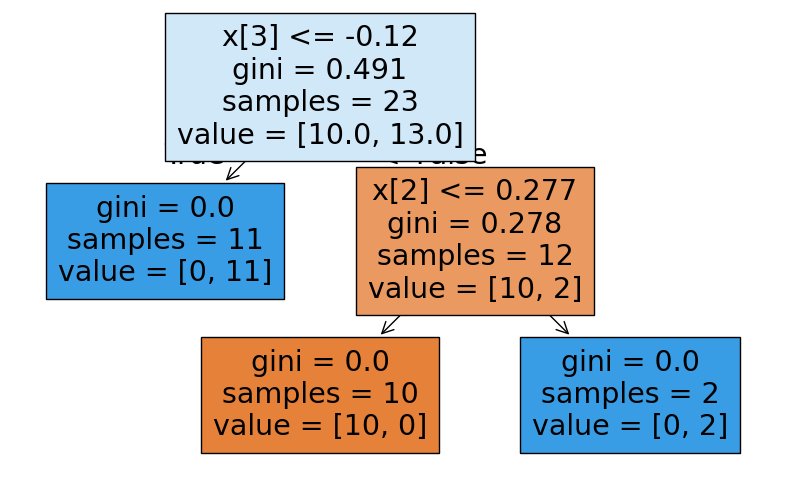

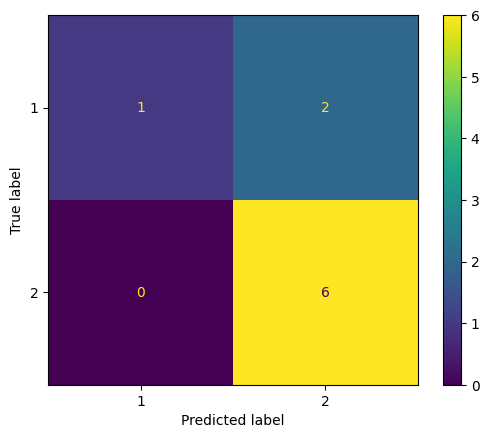

In [ ]:
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 10),
    'min_samples_split': np.arange(2, 10),
    'min_samples_leaf': np.arange(1, 5),
    'class_weight': ['balanced', None]
}

clf2 = DecisionTreeClassifier(random_state=42)
clf2 = clf2.fit(Xt, Yt)
random_search = RandomizedSearchCV(
    clf2,
    param_distributions=param_dist,
    n_iter=20,  
    cv=StratifiedKFold(n_splits=5), 
    scoring=make_scorer(f1_score,  average='weighted'), 
    random_state=42
)

random_search.fit(Xt, Yt)

print("Najlepsze parametry:", random_search.best_params_)
print("Najlepszy F1-Score:", random_search.best_score_)
Yv_pred_random = clf2.predict(Xv)

precision = precision_score(Yv, Yv_pred_random, average='weighted')
recall = recall_score(Yv, Yv_pred_random, average='weighted')
f1 = f1_score(Yv, Yv_pred_random, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
plt.figure(figsize=(10, 6))
plot_tree(clf2, filled=True, )
plt.show()
Yv_pred_random = clf2.predict(Xv)
conmat_random = confusion_matrix(Yv, Yv_pred_random)
conmandis_random = ConfusionMatrixDisplay(confusion_matrix=conmat_random, display_labels=clf2.classes_)
conmandis_random.plot()
plt.show()

Interpretacja wyników:


Według zastosowanych metod optymalizacji i podstawowej metody wygenerowana macierz pomyłek jest taka sama (TP=1, FP=2, FN=0, TN=6). Konkretne statystyki różnią się od siebie. Obie metody optymalizacji mają wyższą precyzję (0.75 do 83.3). Pomimo znalezienia różnych najlepszych parametrów precison dla obu metod optymalizacji wynosi tyle samo. Można po tym znioskować, że tak mała próba uniemożliwia większą wariancję od siebie. Najwyższy wynik F-score ma i tak metoda bez żadnej optymalizacji, co równa się ~ 0.86.